In [49]:
#look through files and make sure they each have more than 125 Hz
#calculate the frequency spectrum (FFT with bandpass and with getting rid of 60Hz and 120Hz artifacts)
#take band averages (eg. 0-5Hz, 5-10Hz)
#save averages in a csv file (each row is a recording, 25 columns)
#separate data into train and test data (80% is training data, 20% is testing data for both epilepsy and nonepilepsy)
#scipy SVM (machine learning), feed in training data with labels saying which is epilepsy vs nonepilepsy
#feed in test data and it will produce accuracy score
# look at specificity (false-positive) and sensitivity(false-negative)
#results section
#bump avg didn't work, but SVM did
#discussion section: why bump averages did not work, why SVM did work
#if sensitivity is low, we could miss a lot of patients that have epilepsy
#if specifity is low, we do not want to give nonepileptic patients drugs for epilepsy


In [104]:
#import block
import mne
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

In [57]:

    
def preprocess_channel(channel, sfreq):
    
    # Time-related parameters
    T = 1 / sfreq
    #print(sfreq)
    #print(T)
    total_time = len(channel) / sfreq
    seconds = np.arange(0, total_time, 1/sfreq)
    N_samples = len(channel)
    #print(total_time)
    #print(seconds)
    #print(N_samples)
    #sos = signal.butter(30, [0.1, 118], 'bp', fs=sfreq, output='sos')
    sos = signal.butter(30, 0.1, 'hp', fs=sfreq, output='sos')
    sos2 = signal.butter(30, [59.5, 60.5], 'bs', fs=sfreq, output='sos')
    sos3 = signal.butter(30, [119.5, 120.5], 'bs', fs=sfreq, output='sos')
    filtered = signal.sosfilt(sos, channel)
    filtered2 = signal.sosfilt(sos2, filtered)
    filtered3 = signal.sosfilt(sos3, filtered2)
    
    return filtered3

def preprocess_channels(channels_data, sfreq):
    new_channels = []
    for channel in channels_data:
        new_channel = preprocess_channel(channel, sfreq)
        #print(new_channel)
        new_channels.append(new_channel)
        #print(new_channel)
    return new_channels


In [58]:
# def bandAvg(S_mag,freq_axis,lower,upper):
#     bool_inside_band = np.logical_and(freq_axis > lower, freq_axis <= upper)
#     mean_in_band = np.mean(S_mag[bool_inside_band])
    
#     return mean_in_band


# def band_avg_all_files(folderName,channel=0 ,max_files_read=10000):
#     band_avg_list_of_lists = []
#     n_files_read = 0
#     for root, dirs, files in os.walk(folderName, topdown=False):
        
#         for filename in files:
#             if (n_files_read >= max_files_read):
#                 return band_avg_list_of_lists
#             #if edf, run bump_avg
#             #function should return a list of all bump averages
#             #run this function for both epileptic and non epileptic folders
#             if (os.path.splitext(filename)[1] == '.edf'):
#                 n_files_read += 1
#                 data = mne.io.read_raw_edf(os.path.join(root, filename), verbose="warning")
#                 raw_data = data.get_data()
#                 # you can get the metadata included in the file and a list of all channels:
#                 info = data.info
#                 channels = data.ch_names

#                 sfreq = info["sfreq"]
#                 # Call preprocess_channels with the list of channels and sfreq
#                 preprocessed_channels = preprocess_channels(raw_data, sfreq)

#                 # Call preprocess_channel for a single channel (replace current_channel with the actual channel data)
#                 current_channel = raw_data[channel]
#                 preprocessed_single_channel = preprocess_channel(current_channel, sfreq)

#                 T= 1/sfreq
#                 total_time = len(current_channel) / sfreq
#                 seconds = np.arange(0, total_time, 1/sfreq)
#                 N_samples = len(current_channel)

#                 #plotting filtered data of the frequency domain
#                 #frequency plot
#                 S2 = np.fft.fft(preprocessed_single_channel)
#                 freq_axis = np.fft.fftfreq(N_samples, T)[:N_samples//2]
#                 S_mag2 = np.abs(S2)
                
#                 band_avg = bandAvg(np.log(S_mag2)[:len(seconds)//2],freq_axis,0,25)
#                 #print(band_avg)
#                 log_s_mag = np.log(S_mag2)[:len(seconds)//2]
#                 band_avg_list = []
#                 #print(band_avg_list)
#                 for interval in range(25):
#                     lower = 5 * interval
#                     upper = lower + 5
#                     #print(lower)
#                     #print(upper)
#                     band_avg_for_interval = bandAvg(log_s_mag, freq_axis, lower, upper)
#                     #print(band_avg_for_interval)
#                     band_avg_list.append(band_avg_for_interval)
#                     #print(band_avg_list)

#                 band_avg_list_of_lists.append(band_avg_list)
#                 #print(band_avg_list_of_lists)

#     return band_avg_list_of_lists

In [59]:
band_avg_all_files("/Users/poulomigangopadhyay/Desktop/epilepsy/epilepsy_edf/aaaaaelp/s002_2010_01_16/01_tcp_ar/aaaaaelp_s002_t000.edf", channel=0)

[]

In [60]:
#run on one file
#try for 5 files, and save to csv name epilepsy5
#run for all of epilepsy and nonepilepsy and save to 2 csv files
#don't overwrite existing files
#try splitting into test and train data (80-20)


In [123]:
def bandAvg(S_mag,freq_axis,lower,upper):
    bool_inside_band = np.logical_and(freq_axis > lower, freq_axis <= upper)
    mean_in_band = np.mean(S_mag[bool_inside_band])
    
    return mean_in_band


def band_avg_all_files(folderName,num_bands = 25,channel=0 ,max_files_read=10000):
    band_avg_list_of_lists = []
    n_files_read = 0
    for root, dirs, files in os.walk(folderName, topdown=False):
        
        for filename in files:
            if (n_files_read >= max_files_read):
                return band_avg_list_of_lists
            #if edf, run bump_avg
            #function should return a list of all bump averages
            #run this function for both epileptic and non epileptic folders
            if (os.path.splitext(filename)[1] == '.edf'):
                n_files_read += 1
                data = mne.io.read_raw_edf(os.path.join(root, filename), verbose="warning")
                raw_data = data.get_data()
                # you can get the metadata included in the file and a list of all channels:
                info = data.info
                channels = data.ch_names

                sfreq = info["sfreq"]
                # Call preprocess_channels with the list of channels and sfreq
                preprocessed_channels = preprocess_channels(raw_data, sfreq)

                # Call preprocess_channel for a single channel (replace current_channel with the actual channel data)
                current_channel = raw_data[channel]
                preprocessed_single_channel = preprocess_channel(current_channel, sfreq)

                T= 1/sfreq
                total_time = len(current_channel) / sfreq
                seconds = np.arange(0, total_time, 1/sfreq)
                N_samples = len(current_channel)

                #plotting filtered data of the frequency domain
                #frequency plot
                S2 = np.fft.fft(preprocessed_single_channel)
                freq_axis = np.fft.fftfreq(N_samples, T)[:N_samples//2]
                S_mag2 = np.abs(S2)
                
                #band_avg = bandAvg(np.log(S_mag2)[:len(seconds)//2],freq_axis,0,25)
                #print(band_avg)
                log_s_mag = np.log(S_mag2)[:len(seconds)//2]
                band_avg_list = []
                #print(band_avg_list)
                #for interval in range(25):
                #     lower = 5 * interval
                #     upper = lower + 5
                    #print(lower)
                    #print(upper)
                band_bounds = np.linspace(0, 125, num= num_bands + 1)
                for interval in range(len(band_bounds)-1):
                    lower = band_bounds[interval]
                    upper = band_bounds[interval+1]
                    band_avg_for_interval = bandAvg(log_s_mag, freq_axis, lower, upper)
                    #print(band_avg_for_interval)
                    band_avg_list.append(band_avg_for_interval)
                    #print(band_avg_list)

                band_avg_list_of_lists.append(band_avg_list)
                #print(band_avg_list_of_lists)

    return band_avg_list_of_lists

In [121]:
np.linspace(0, 125, num=26)

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125.])

TypeError: unsupported operand type(s) for -: 'list' and 'list'

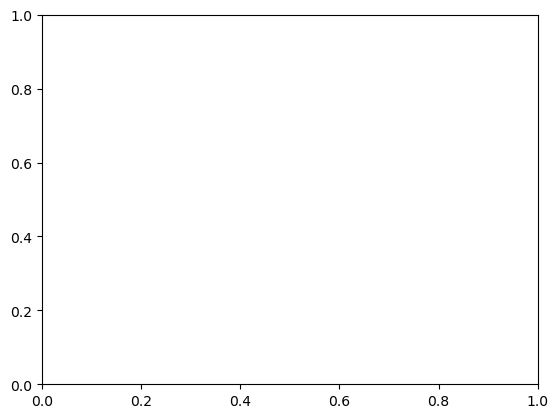

In [64]:
epilepsy_df = pd.DataFrame(np.array(list((band_avg_all_files('epilepsy_edf')))))
nonepilepsy_df = pd.DataFrame(np.array(list((band_avg_all_files('no_epilepsy_edf')))))

In [76]:
epilepsy_df.to_csv('machineLearningepilepsy.csv', index=False)
nonepilepsy_df.to_csv('machineLearningNonepilepsy.csv', index=False)
#plt.boxplot([epilepsy_df.dropna(),nonepilepsy_df.dropna()])

In [74]:
# epilepsy_df = pd.DataFrame(np.array(list(epilepsy_series)))
# nonepilepsy_df = pd.DataFrame(np.array(list(nonepilepsy_series)))

In [78]:
frames = [epilepsy_df,nonepilepsy_df]

combined_df = pd.concat(frames)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-3.625277,-3.954651,-4.140190,-4.407559,-4.722475,-5.046830,-5.343451,-5.572502,-5.769275,-5.944762,...,-6.563568,-6.584948,-6.666414,-6.692539,-6.703440,-6.788776,-7.076042,-7.540765,-8.392453,-8.907329
1,-4.537405,-5.509308,-5.552030,-5.804036,-5.875350,-5.927027,-5.939186,-5.975638,-5.957868,-5.985602,...,-6.192116,-6.303428,-6.347113,-6.410220,-6.415021,-6.526773,-6.833694,-7.236252,-8.499992,-9.054837
2,-4.021726,-4.997517,-5.323696,-5.681880,-5.758615,-5.845292,-6.089977,-6.167310,-6.178126,-6.147372,...,-6.236295,-6.205535,-6.216982,-6.280975,-6.268779,-6.341027,-6.589798,-7.021270,-8.050568,-8.521218
3,-1.924693,-3.070059,-3.403422,-3.727316,-3.971027,-4.074180,-4.357626,-4.569777,-4.596468,-4.613221,...,-5.062901,-4.990841,-5.060379,-5.221576,-5.367406,-5.313665,-5.373696,-5.768574,-6.435940,-6.379975
4,-4.011737,-5.060310,-5.318742,-5.558484,-5.457561,-5.500486,-5.759968,-5.946427,-5.894189,-5.935883,...,-5.964641,-5.941599,-5.993292,-5.986871,-6.030438,-6.072921,-6.289987,-6.731977,-7.677077,-8.201552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,-2.153642,-3.215265,-3.880666,-4.370049,-4.487631,-4.811183,-4.935573,-5.203724,-5.112903,-4.906348,...,-5.601734,-5.060708,-6.224261,-5.268702,-5.882347,-5.987061,-5.597839,-6.407784,-6.942984,-6.739567
509,-1.589749,-2.391909,-3.040971,-3.459054,-3.405772,-3.798836,-4.112380,-4.032521,-4.045373,-4.364513,...,-4.588623,-4.615993,-4.664153,-4.844393,-4.622434,-4.834044,-4.847673,-5.065047,-5.183413,-5.165241
510,-4.107066,-5.434799,-5.437097,-5.769350,-5.938236,-6.132079,-6.247815,-6.295425,-6.309713,-6.266774,...,-6.248762,-6.271732,-6.283047,-6.238030,-6.207778,-6.332794,-6.561139,-7.015812,-7.847560,-8.303119
511,-5.539852,-6.882194,-6.997428,-7.365968,-7.601131,-7.837759,-8.005227,-8.110814,-8.043691,-8.086562,...,-8.022645,-8.113542,-8.060835,-7.996106,-8.081365,-8.146232,-8.298755,-8.811194,-9.591502,-9.898574


In [83]:
epilepsy_ones = np.ones(epilepsy_df.shape[0])
nonepilepsy_zeros = np.zeros(nonepilepsy_df.shape[0])
labels = np.concatenate([epilepsy_ones,nonepilepsy_zeros])

In [112]:
X_train, X_test, y_train, y_test = train_test_split(combined_df, labels, test_size=0.33, random_state=42)

In [113]:
#SVM Model
model = SVC(kernel = "linear",class_weight = {0: 3})
model.fit(X_train, y_train)


0.7562582345191041

In [114]:
np.sum(y_test)

573.0

In [117]:
#specificity: y_test is false but test_predicted is false
def checkSpecificity(y_test,test_predicted):
    count1 = 0
    for value in range(len(y_test)):
        if (y_test[value]== False and test_predicted[value]== False):
            count1 += 1
    specificity = count1/(len(y_test)- np.sum(y_test))
    return specificity

#sensitivity: y_test and test_predicted is both true
def checkSensitivity(y_test,test_predicted):
    count1 = 0
    for value in range(len(y_test)):
        if (y_test[value]== True and test_predicted[value]== True):
            count1 += 1
    sensitivity = count1/np.sum(y_test)
    return sensitivity

def checkAccuracy(y_test,test_predicted):
    return np.mean(np.equal(test_predicted,y_test))

In [118]:
test_predicted = model.predict(X_test)
print(checkSpecificity(y_test,test_predicted))
print(checkSensitivity(y_test,test_predicted))
print(checkAccuracy(y_test,test_predicted))

0.6397849462365591
0.794066317626527
0.7562582345191041


In [107]:
#Neural Network
frames = [epilepsy_df,nonepilepsy_df]
combined_df = pd.concat(frames)
epilepsy_ones = np.ones(epilepsy_df.shape[0])
nonepilepsy_zeros = np.zeros(nonepilepsy_df.shape[0])
labels = np.concatenate([epilepsy_ones,nonepilepsy_zeros])

#split into train,test, and validation
X_train2, X_test2, y_train2, y_test2 = train_test_split(combined_df, labels, test_size=0.2, random_state=42)

#split training set into training and validation sets
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.1, random_state=42)

#neural network model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(num_bands, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train2, y_train2, epochs=len(y_test2), validation_data=(X_val2, y_val2))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test2, y_test2)
print(f'Test accuracy: {test_acc}')


Epoch 1/460
52/52 [==============================] - 0s 7ms/step - loss: 0.5492 - accuracy: 0.7715 - val_loss: 0.5047 - val_accuracy: 0.8043
Epoch 2/460
52/52 [==============================] - 0s 697us/step - loss: 0.5407 - accuracy: 0.7775 - val_loss: 0.5065 - val_accuracy: 0.8043
Epoch 3/460
52/52 [==============================] - 0s 689us/step - loss: 0.5179 - accuracy: 0.7781 - val_loss: 0.4784 - val_accuracy: 0.8043
Epoch 4/460
52/52 [==============================] - 0s 708us/step - loss: 0.5118 - accuracy: 0.7823 - val_loss: 0.4995 - val_accuracy: 0.8043
Epoch 5/460
52/52 [==============================] - 0s 709us/step - loss: 0.5130 - accuracy: 0.7884 - val_loss: 0.4632 - val_accuracy: 0.8043
Epoch 6/460
52/52 [==============================] - 0s 699us/step - loss: 0.4913 - accuracy: 0.7854 - val_loss: 0.4545 - val_accuracy: 0.8043
Epoch 7/460
52/52 [==============================] - 0s 671us/step - loss: 0.4892 - accuracy: 0.7866 - val_loss: 0.4587 - val_accuracy: 0.8043
E

In [119]:
#for cnn
test_predicted2 = model.predict(X_test2)
print(checkSpecificity(y_test2,test_predicted2))
print(checkSensitivity(y_test2,test_predicted2))
print(checkAccuracy(y_test2,test_predicted2))

0.6545454545454545
0.7942857142857143
0.7608695652173914


In [85]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
874,-4.527201,-5.648631,-6.416089,-6.908481,-7.254647,-7.271532,-7.271185,-7.194711,-7.210508,-7.117188,...,-7.534829,-7.470009,-7.536370,-7.792974,-7.769201,-7.890094,-7.886058,-7.996862,-8.368517,-8.197267
893,-1.943734,-2.425521,-2.473288,-2.577116,-2.939599,-3.520564,-3.915840,-4.066689,-4.168173,-4.186661,...,-4.734472,-4.879567,-4.849460,-5.004949,-5.096823,-5.167333,-5.216742,-5.264587,-5.794230,-5.804524
53,-3.650335,-4.613752,-4.822936,-5.129178,-5.150807,-5.238975,-5.564944,-5.721992,-5.807171,-5.894160,...,-6.285060,-6.380050,-6.453392,-6.552448,-6.666861,-6.735529,-6.829920,-6.907210,-7.400224,-7.438626
1221,-3.258205,-4.660194,-5.491717,-5.580287,-5.641275,-5.551534,-5.529789,-5.520271,-5.489455,-5.434684,...,-5.511058,-5.500525,-5.515853,-5.545299,-5.554448,-5.606751,-5.833301,-6.285463,-7.303893,-7.740338
1292,-3.842827,-4.978407,-5.739617,-6.187209,-6.428933,-6.711526,-6.929903,-6.990506,-7.054117,-7.119644,...,-7.468164,-7.537534,-7.625615,-7.684568,-7.794171,-7.886954,-7.970989,-8.068985,-8.387369,-8.423897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,-3.968631,-4.741328,-4.583201,-4.819477,-4.930591,-5.291063,-5.772545,-5.985122,-6.162721,-6.293428,...,-6.557162,-6.604144,-6.673520,-6.722084,-6.772103,-6.865449,-7.097770,-7.584864,-8.436832,-8.912294
1095,-3.989193,-5.209252,-4.926412,-5.865930,-5.541296,-5.084706,-6.408569,-5.177997,-5.658363,-6.266259,...,-5.588177,-6.633285,-6.296220,-5.908945,-7.084131,-6.121015,-6.568582,-6.827983,-6.818568,-7.339927
1130,-2.986736,-4.556365,-4.981422,-5.015463,-5.108326,-5.149165,-5.177656,-5.228795,-5.329654,-5.382289,...,-6.026162,-6.128485,-6.251329,-6.390891,-6.556164,-6.732293,-6.841097,-7.014740,-7.469461,-7.554635
1294,-3.000366,-4.373640,-4.825848,-5.065798,-5.235636,-5.291163,-5.356544,-5.539132,-5.651439,-5.738407,...,-6.363884,-6.452354,-6.557554,-6.654636,-6.734852,-6.804645,-6.868787,-6.978237,-7.161636,-7.200457


In [63]:
band_avg_all_files('no_epilepsy_edf')

[[-4.402511915343329,
  -5.4707718709354145,
  -5.893955467816698,
  -6.233731005755416,
  -6.532972328897046,
  -6.865674651890196,
  -6.843893361854688,
  -6.659684226149958,
  -7.00160137042884,
  -7.2799897603030015,
  -7.44657434387775,
  -8.056899081485545,
  -8.047047207491188,
  -7.555537969133425,
  -7.6115498870681,
  -7.610650071873997,
  -7.638364702786336,
  -7.689725196469785,
  -7.662198415430451,
  -7.729998968692198,
  -7.73839905067205,
  -7.994941361178127,
  -8.463794525423955,
  -9.438003514636968,
  -9.854733233439875],
 [-6.553441451330806,
  -7.8467363639959595,
  -8.259723470542506,
  -8.668947226881633,
  -9.112149635335609,
  -9.366540036438762,
  -9.669693183509128,
  -9.721969859416326,
  -10.101873887874511,
  -10.044061989373013,
  -10.395621895054735,
  -10.32556907233581,
  -10.74074538610818,
  -10.330457046818589,
  -10.53505892634812,
  -10.456437503325951,
  -10.774156179136916,
  -10.377226712018714,
  -10.994392190720589,
  -10.474909324923205,
  

In [125]:
num_bands =10
epilepsy_df = pd.DataFrame(np.array(list((band_avg_all_files('epilepsy_edf',num_bands)))))
nonepilepsy_df = pd.DataFrame(np.array(list((band_avg_all_files('no_epilepsy_edf',num_bands)))))
epilepsy_df.to_csv('machineLearningepilepsy'+str(num_bands)+'.csv', index=False)
nonepilepsy_df.to_csv('machineLearningNonepilepsy'+str(num_bands)+'.csv', index=False)
frames = [epilepsy_df,nonepilepsy_df]
combined_df = pd.concat(frames)
epilepsy_ones = np.ones(epilepsy_df.shape[0])
nonepilepsy_zeros = np.zeros(nonepilepsy_df.shape[0])
labels = np.concatenate([epilepsy_ones,nonepilepsy_zeros])

In [126]:
#split into train,test, and validation
X_train3, X_test3, y_train3, y_test3 = train_test_split(combined_df, labels, test_size=0.2, random_state=42)

#split training set into training and validation sets
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=0.1, random_state=42)

#neural network model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(num_bands, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train3, y_train3, epochs=len(y_test3), validation_data=(X_val3, y_val3))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test3, y_test3)
print(f'Test accuracy: {test_acc}')


Epoch 1/460
52/52 [==============================] - 0s 2ms/step - loss: 0.6179 - accuracy: 0.7430 - val_loss: 0.5173 - val_accuracy: 0.8043
Epoch 2/460
52/52 [==============================] - 0s 588us/step - loss: 0.5423 - accuracy: 0.7781 - val_loss: 0.5245 - val_accuracy: 0.8043
Epoch 3/460
52/52 [==============================] - 0s 542us/step - loss: 0.5292 - accuracy: 0.7781 - val_loss: 0.4903 - val_accuracy: 0.8043
Epoch 4/460
52/52 [==============================] - 0s 543us/step - loss: 0.5143 - accuracy: 0.7787 - val_loss: 0.4706 - val_accuracy: 0.8043
Epoch 5/460
52/52 [==============================] - 0s 561us/step - loss: 0.5084 - accuracy: 0.7793 - val_loss: 0.4625 - val_accuracy: 0.8043
Epoch 6/460
52/52 [==============================] - 0s 582us/step - loss: 0.4967 - accuracy: 0.7823 - val_loss: 0.4557 - val_accuracy: 0.8098
Epoch 7/460
52/52 [==============================] - 0s 584us/step - loss: 0.4900 - accuracy: 0.7848 - val_loss: 0.4487 - val_accuracy: 0.8098
E

In [127]:
num_bands =50
epilepsy_df = pd.DataFrame(np.array(list((band_avg_all_files('epilepsy_edf',num_bands)))))
nonepilepsy_df = pd.DataFrame(np.array(list((band_avg_all_files('no_epilepsy_edf',num_bands)))))
epilepsy_df.to_csv('machineLearningepilepsy'+str(num_bands)+'.csv', index=False)
nonepilepsy_df.to_csv('machineLearningNonepilepsy'+str(num_bands)+'.csv', index=False)
frames = [epilepsy_df,nonepilepsy_df]
combined_df = pd.concat(frames)
epilepsy_ones = np.ones(epilepsy_df.shape[0])
nonepilepsy_zeros = np.zeros(nonepilepsy_df.shape[0])
labels = np.concatenate([epilepsy_ones,nonepilepsy_zeros])
#split into train,test, and validation
X_train4, X_test4, y_train4, y_test4 = train_test_split(combined_df, labels, test_size=0.2, random_state=42)

#split training set into training and validation sets
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_train4, y_train4, test_size=0.1, random_state=42)

#neural network model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(num_bands, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train4, y_train4, epochs=len(y_test4), validation_data=(X_val4, y_val4))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test4, y_test4)
print(f'Test accuracy: {test_acc}')


Epoch 1/460
52/52 [==============================] - 0s 2ms/step - loss: 0.5588 - accuracy: 0.7672 - val_loss: 0.4991 - val_accuracy: 0.8043
Epoch 2/460
52/52 [==============================] - 0s 932us/step - loss: 0.5251 - accuracy: 0.7781 - val_loss: 0.5480 - val_accuracy: 0.8207
Epoch 3/460
52/52 [==============================] - 0s 978us/step - loss: 0.5238 - accuracy: 0.7836 - val_loss: 0.4774 - val_accuracy: 0.8043
Epoch 4/460
52/52 [==============================] - 0s 984us/step - loss: 0.5086 - accuracy: 0.7866 - val_loss: 0.4750 - val_accuracy: 0.8152
Epoch 5/460
52/52 [==============================] - 0s 979us/step - loss: 0.5127 - accuracy: 0.7781 - val_loss: 0.4610 - val_accuracy: 0.8043
Epoch 6/460
52/52 [==============================] - 0s 996us/step - loss: 0.4955 - accuracy: 0.7896 - val_loss: 0.5265 - val_accuracy: 0.8207
Epoch 7/460
52/52 [==============================] - 0s 1ms/step - loss: 0.4830 - accuracy: 0.7926 - val_loss: 0.4520 - val_accuracy: 0.8152
Epo

In [130]:
test_predicted4 = model.predict(X_test4)
print(checkSpecificity(y_test4,test_predicted4))
print(checkSensitivity(y_test4,test_predicted4))
print(checkAccuracy(y_test4,test_predicted4))

ValueError: in user code:

    File "/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Applications/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 100, 1), found shape=(None, 50)


In [129]:
num_bands =100
epilepsy_df = pd.DataFrame(np.array(list((band_avg_all_files('epilepsy_edf',num_bands)))))
nonepilepsy_df = pd.DataFrame(np.array(list((band_avg_all_files('no_epilepsy_edf',num_bands)))))
epilepsy_df.to_csv('machineLearningepilepsy'+str(num_bands)+'.csv', index=False)
nonepilepsy_df.to_csv('machineLearningNonepilepsy'+str(num_bands)+'.csv', index=False)
frames = [epilepsy_df,nonepilepsy_df]
combined_df = pd.concat(frames)
epilepsy_ones = np.ones(epilepsy_df.shape[0])
nonepilepsy_zeros = np.zeros(nonepilepsy_df.shape[0])
labels = np.concatenate([epilepsy_ones,nonepilepsy_zeros])
#split into train,test, and validation
X_train5, X_test5, y_train5, y_test5 = train_test_split(combined_df, labels, test_size=0.2, random_state=42)

#split training set into training and validation sets
X_train5, X_val5, y_train5, y_val5 = train_test_split(X_train5, y_train5, test_size=0.1, random_state=42)

#neural network model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(num_bands, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train5, y_train5, epochs=len(y_test5), validation_data=(X_val5, y_val5))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test5, y_test5)
print(f'Test accuracy: {test_acc}')


Epoch 1/460
52/52 [==============================] - 0s 3ms/step - loss: 0.7202 - accuracy: 0.7237 - val_loss: 0.4870 - val_accuracy: 0.8043
Epoch 2/460
52/52 [==============================] - 0s 1ms/step - loss: 0.5128 - accuracy: 0.7793 - val_loss: 0.4685 - val_accuracy: 0.8043
Epoch 3/460
52/52 [==============================] - 0s 1ms/step - loss: 0.4944 - accuracy: 0.7817 - val_loss: 0.4509 - val_accuracy: 0.8098
Epoch 4/460
52/52 [==============================] - 0s 1ms/step - loss: 0.5111 - accuracy: 0.7854 - val_loss: 0.4570 - val_accuracy: 0.8207
Epoch 5/460
52/52 [==============================] - 0s 1ms/step - loss: 0.4906 - accuracy: 0.7854 - val_loss: 0.4712 - val_accuracy: 0.8315
Epoch 6/460
52/52 [==============================] - 0s 1ms/step - loss: 0.4688 - accuracy: 0.7914 - val_loss: 0.4335 - val_accuracy: 0.8207
Epoch 7/460
52/52 [==============================] - 0s 1ms/step - loss: 0.4782 - accuracy: 0.7950 - val_loss: 0.4321 - val_accuracy: 0.8207
Epoch 8/460
5

In [131]:
test_predicted5 = model.predict(X_test5)
print(checkSpecificity(y_test4,test_predicted5))
print(checkSensitivity(y_test4,test_predicted5))
print(checkAccuracy(y_test4,test_predicted5))

15/15 [==============================] - 0s 555us/step
0.0
0.2342857142857143
0.14555765595463138
